In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Getting data

In [3]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [4]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.


In [6]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

Random image path: data/pizza_steak_sushi/test/steak/100274.jpg
Image class: steak
Image height: 384
Image width: 512


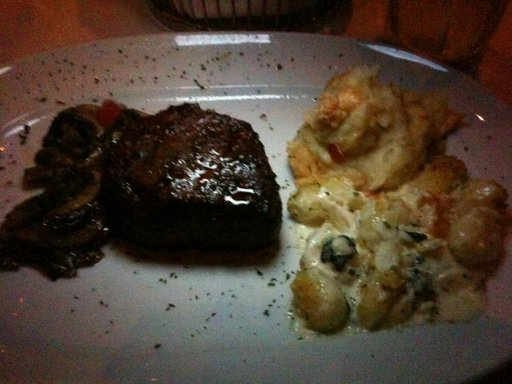

In [7]:
import random
from PIL import Image

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

Transforming data into Tensor format

In [8]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

Let's do some transformation on our data

In [9]:
from torchvision.transforms.transforms import RandomHorizontalFlip
data_transform = transforms.Compose([
                                     #Resize the image to 64x64
                                     transforms.Resize(size=(64,64)),
                                     #flip the image randomly on the horizontal
                                     transforms.RandomHorizontalFlip(p=0.5),#probability of flip
                                     #turns image into a torch.tensor
                                     transforms.ToTensor()
                                     ])

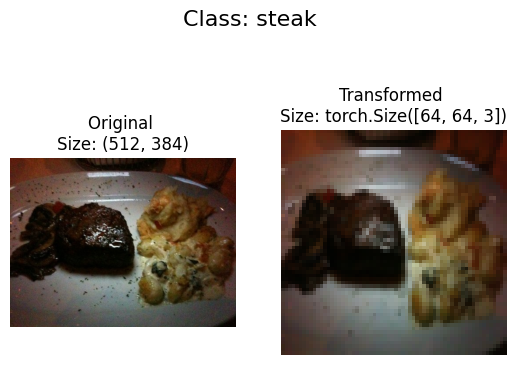

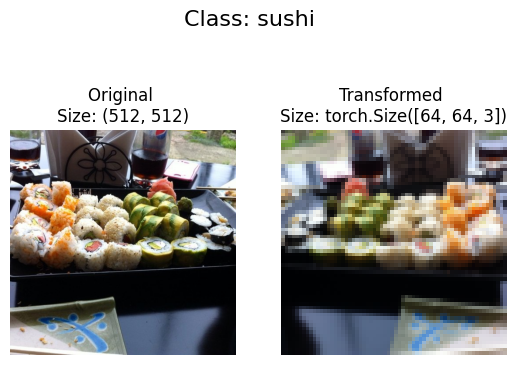

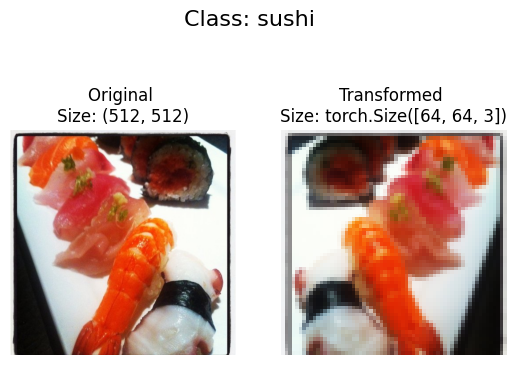

In [10]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths.
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)

## Loading image data
For this we have several options

### Option 1: Loading Image Data Using `ImageFolder`

Since our data is in standard image classification format, we can use the class torchvision.datasets.ImageFolder.

In [11]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, #transform to perform on data (images), the one we wrote before
                                  target_transform=None, #transforms to perform on labels if necessary
                                  )

test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)

In [12]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [13]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

#### Turn Loaded Images Into `DataLoader`'s

Doing it make our dataset iterable so a model can go through, learn the relationships between samples and targets (features and labels)

In [14]:
os.cpu_count()

2

In [15]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32, #how many samples per batch
                              num_workers=os.cpu_count(),#how many subprocesses to use
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=32,
                             num_workers=os.cpu_count(),
                             shuffle=True)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7d0bff1cc5b0>,
 <torch.utils.data.dataloader.DataLoader at 0x7d0bfecd4040>)

Let's check the shapes

In [16]:
img, label = next(iter(train_dataloader))
# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


### Option 2: Loading Image Data with a Custom `Dataset`

What if a pre-built `Dataset` creator like the one we are using doesn't exist?
Nevertheless, the directory should have the structure:
\
-folder category 1:\
    -image1\
    -image2\
    ...\
    \
-foder category 2:\
    - image3\
    - image4\
    ...

In [17]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [18]:
# Setup path for target directory
target_directory = train_dir
print(f"Target directory: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
print(f"Class names found: {class_names_found}")

Target directory: data/pizza_steak_sushi/train
Class names found: ['pizza', 'steak', 'sushi']


In [19]:
# Make function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.

    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))

    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")

    # 3. Create a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [20]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

#### Create a custom `Dataset` to replicate `ImageFolder`

In [21]:
from torch.utils.data import Dataset

class ImageFolderCustom(Dataset):

  def __init__(self, targ_dir: str, transform=None) -> None:
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    self.transform = transform
    self.classes, self.class_to_idx = find_classes(targ_dir)

  def load_image(self, index:int) -> Image.Image:
    image_path = self.paths[index]
    return Image.open(image_path)

  def __len__(self) -> int:
    return len(self.paths)

  def __getitem__(self, index:int) -> Tuple[torch.Tensor, int]:
    img = self.load_image(index)
    class_name = self.Paths[index].parent.name
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img)
    else:
      return img, class_idx

Let's create some transforms

In [22]:
train_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

Now, let's use the class we have created along with the transforms

In [23]:
train_data_custom = ImageFolderCustom(train_dir,train_transforms)

test_data_custom = ImageFolderCustom(test_dir, test_transforms)

train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7d0bfecf63b0>,
 <__main__.ImageFolderCustom at 0x7d0cdfdca8c0>)

In [24]:
len(train_data_custom)

225

In [25]:
train_data_custom.classes, train_data_custom.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### Create a function to display random images

In [26]:
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                         classes: List[str]=None,
                         n:int=10,
                         display_shape:bool = True,
                         seed: int=None):

  #2. Adjust display if n is too high
  if n>10:
    n=10
    display_shape = False
    print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

  #3. Set random seed
  if seed:
    random.seed(seed)

  #4. Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  #5. setup plot
  plt.figure(figsize=(16,8))

  #6. Loop through samples and display random samples
  for i, targ_sample in enumerate(random_samples_idx):
    targ_img, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    #7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [ height, width,color_channels ]
    targ_image_adjust = targ_img.permute(1,2,0)

    #Plot adjusted samples
    plt.subplot(1,n,i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title= f"class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
      plt.title(title)

For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.


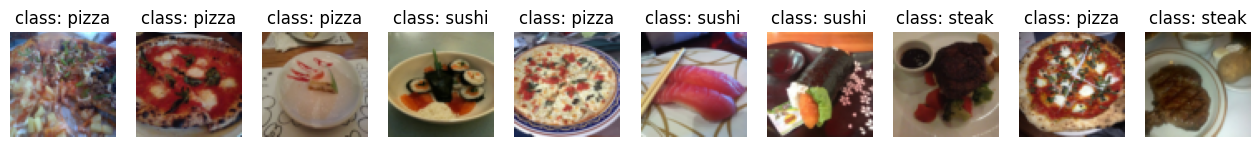

In [27]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data,
                      n=50,
                      classes=class_names,
                      seed=None)

### Turn custom loaded images into `DataLoader`'s

We can use `torch.utils.data.DataLoader()` to turn our `Dataset` into `DataLoader`'s because our custom Dataset subclass `torch.utis.data.Dataset`. We can use them directly with `torch.utils.data.DataLoader()`

In [28]:
# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader
train_dataloader_custom = DataLoader(dataset=train_data_custom, # use custom created train Dataset
                                     batch_size=32, # how many samples per batch?
                                     num_workers=os.cpu_count(), # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

test_dataloader_custom = DataLoader(dataset=test_data_custom, # use custom created test Dataset
                                    batch_size=32,
                                    num_workers=os.cpu_count(),
                                    shuffle=True) # don't usually need to shuffle testing data

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7d0bf7e1b310>,
 <torch.utils.data.dataloader.DataLoader at 0x7d0bf7e18730>)

Using `transforms.TrivialAugmentWide()` to improve our dataset variety and randomness

In [29]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense
    transforms.ToTensor() # use ToTensor() last to get everything between 0 & 1
])

# Don't need to perform augmentation on the test data
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

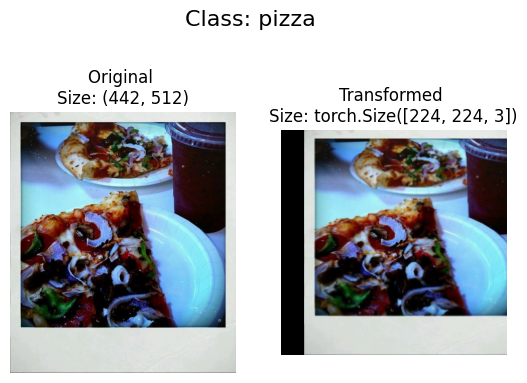

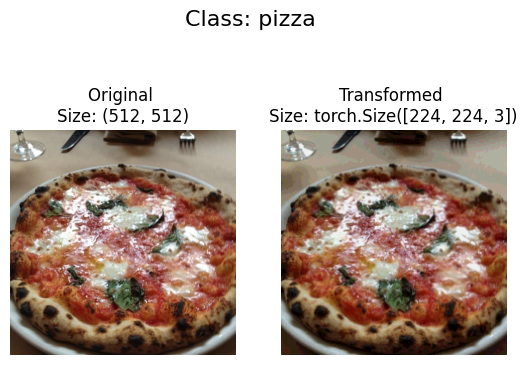

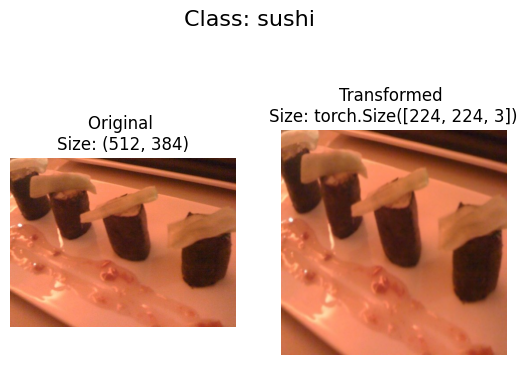

In [30]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Plot random images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=None
)

## Creating the Model

In [31]:
class TinyVGG(nn.Module):
  def __init__(self, input_shape:int, hidden_units:int, output_shape:int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)

        )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units,kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*16*16,
                  out_features=output_shape)
    )

  def forward(self,x: torch.Tensor):
    #x = self.conv_block_1(x)
    #x = self.conv_block_2(x)
    #x = self.classifier(x)

    #This way is faster than the previous one
    return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

    #return x

In [32]:
model_0 = TinyVGG(input_shape=3, hidden_units=10, output_shape = len(train_data.classes)).to(device)

In [33]:
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

### Use torchinfo to get an idea of the shapes going through our model¶


In [34]:
# Install torchinfo if it's not available, import it if it is
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary


In [35]:
summary(model_0, input_size=[1, 3, 64, 64]) # do a test pass through of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

### Create train & test loop functions

In [36]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  model.train()

  train_loss, train_acc = 0,0

  for batch, (X,y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    #1. Forward pass
    y_pred = model(X)

    #2. calculate and accumulate loss
    loss = loss_fn(y_pred,y)
    train_loss += loss.item()

    #3. optimizer zero grad
    optimizer.zero_grad()

    #4. Loss backward
    loss.backward()

    #5. optimizer step
    optimizer.step()

    #calculate and accumuate accuracy metric across all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1),dim=1)
    train_acc += (y_pred_class ==y ).sum().item()/len(y_pred)

  train_loss = train_loss/len(dataloader)
  train_acc = train_acc/len(dataloader)
  return train_loss, train_acc

In [37]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = torch.argmax(torch.softmax(test_pred_logits, dim=1),dim=1)#test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [38]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

### Train and evaluate Model_0

In [39]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [40]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

# 2. Turn data into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
train_dataloader_simple = DataLoader(train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader_simple, test_dataloader_simple

Creating DataLoader's with batch size 32 and 2 workers.


(<torch.utils.data.dataloader.DataLoader at 0x7d0bf7c522f0>,
 <torch.utils.data.dataloader.DataLoader at 0x7d0bf7c53940>)

In [44]:
NUM_EPOCHS = 5
model_0 = TinyVGG(input_shape=3,
                   hidden_units=10,
                   output_shape=len(train_data.classes)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),lr = 0.001)

from timeit import default_timer as timer
start_time = timer()

model_0_results = train(model=model_0,
                       train_dataloader=train_dataloader_simple,
                       test_dataloader=test_dataloader_simple,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=NUM_EPOCHS)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0980 | train_acc: 0.3945 | test_loss: 1.1322 | test_acc: 0.1979
Epoch: 2 | train_loss: 1.0855 | train_acc: 0.4141 | test_loss: 1.1493 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.1202 | train_acc: 0.2930 | test_loss: 1.1612 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.1103 | train_acc: 0.3047 | test_loss: 1.1097 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0830 | train_acc: 0.3203 | test_loss: 1.0495 | test_acc: 0.5426
Total training time: 6.897 seconds


### Plot the loss curves of Model 0

In [45]:
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [46]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

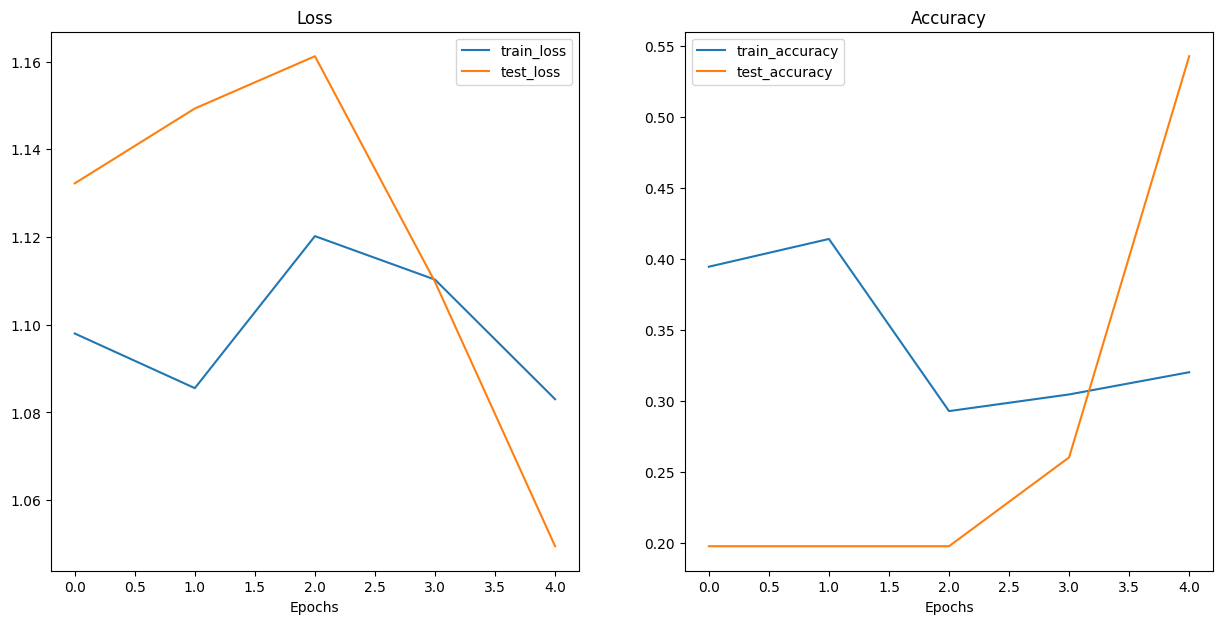

In [47]:
plot_loss_curves(model_0_results)